## Part 2: Non-stationary bandit problem

In [ ]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Configuration parameters (From Assignment)
k = 10              # Number of arms
steps = 2000        # Number of steps
simulations = 1000  # Number of simulations

# Algorithm parameters from Part 1
epsilon = 0.05      # For epsilon-greedy
opt_value = 4.0     # For optimistic greedy (Q0)
alpha = 0.05        # For gradient bandit

# Environment parameters
drift_std = 0.01    # Standard deviation for drift and mean-reverting changes
kappa = 0.5         # Mean reversion parameter

## Gradual changes

## Functions to apply different types of environmental changes ( Drift, Mean Reverting, and Abrupt Changes)

In [ ]:
def apply_update(true_mean, original_mean, update_type, rng, permutation=None):

    if update_type == "drift":
      # drift: μ_{i,t} = μ_{i,t-1} + ε_{i,t} where ε ~ N(0, 0.01²)
        return true_mean + rng.normal(0, drift_std, k)
    elif update_type == "mean_reverting":
      # mean_reverting: μ_{i,t} = κμ_{i,t-1} + ε_{i,t} where κ=0.5, ε ~ N(0, 0.01²)
        return kappa * true_mean + rng.normal(0, drift_std, k)
    elif update_type == "abrupt":
      # abrupt: randomly permute arm means at t=501
        return true_mean[permutation]
    else:
        return true_mean  # No change for stationary case

In [ ]:
# Comprehensive bandit simulation function
# Running multi-armed bandit simulation with specified algorithm and environment type

# algorithm: "greedy", "epsilon", "optimistic", "gradient"
# update_type: "drift", "mean_reverting", "abrupt", "stationary"
# reset: whether to reset Q-values after abrupt change (only for abrupt type)

def run_bandit(algorithm="greedy", update_type="drift", reset=False):

    avg_rewards = np.zeros(steps)
    opt_action_per = np.zeros(steps)

    for s in range(simulations):
        # Create local Random Number Generator (rng) for reproducibility
        # rng = np.random.default_rng(seed=s % 10) # initially tested with 10 seeds but curves are jumping between extremes (unrealistic pattern /uninterpretable)
        rng = np.random.default_rng(seed=s)

        # Initialize environment
        true_mean = rng.normal(0, 1, k)
        original_mean = np.copy(true_mean)
        permutation = rng.permutation(k)
        best_arm = np.argmax(true_mean)

        # Initialize algorithm variables
        N = np.zeros(k)  # Action counts
        H = np.zeros(k)  # Preferences for gradient bandit
        baseline = 0     # Baseline for gradient bandit

        # Initialize Q-values based on algorithm
        if algorithm == "optimistic":
            Q = np.ones(k) * opt_value  # Optimistic initialization
        else:
            Q = np.zeros(k)  # Zero initialization

        # Main simulation loop
        for t in range(steps):
            # Action selection based on algorithm
            if algorithm == "greedy":
                action = rng.choice(np.flatnonzero(Q == Q.max()))   # if multiple actions share the max value, randomly choose one among them
            elif algorithm == "epsilon":
                if rng.random() < epsilon:
                    action = rng.integers(k)  # Explore
                else:
                    action = rng.choice(np.flatnonzero(Q == Q.max()))  # Exploit  :# if multiple actions share the max value, randomly choose one among them
            elif algorithm == "optimistic":
                action = rng.choice(np.flatnonzero(Q == Q.max()))     # if multiple actions share the max value, randomly choose one among them
            elif algorithm == "gradient":
                # Softmax action selection
                exp_H = np.exp(H - np.max(H))  # Numerical stability
                probs = exp_H / np.sum(exp_H)
                action = rng.choice(k, p=probs)

            # Generate reward and record performance
            reward = rng.normal(true_mean[action], 1)
            avg_rewards[t] += reward
            # Set count to 1 if the best arm was selected
            if action == best_arm:
                opt_action_per[t] += 1

            # Update algorithm parameters
            if algorithm in ["greedy", "epsilon", "optimistic"]:
                N[action] += 1
                Q[action] += (reward - Q[action]) / N[action]  # Incremental average
            elif algorithm == "gradient":
                # Update baseline (average reward)
                baseline += (reward - baseline) / (t + 1)

                # Update preferences
                for a in range(k):
                    if a == action:
                        H[a] += alpha * (reward - baseline) * (1 - probs[a])
                    else:
                        H[a] -= alpha * (reward - baseline) * probs[a]

            # Apply environmental changes
            if t == 500 and update_type == "abrupt":
                # Abrupt change at step 501
                true_mean = apply_update(true_mean, original_mean, update_type, rng, permutation)
                best_arm = np.argmax(true_mean)

                # Optional reset of algorithm state
                if reset:
                    if algorithm == "optimistic":
                        Q = np.ones(k) * opt_value
                    else:
                        Q = np.zeros(k)
                    N = np.zeros(k)
                    H = np.zeros(k)
                    baseline = 0

            elif update_type in ["drift", "mean_reverting"]:
                # Gradual changes applied every step
                true_mean = apply_update(true_mean, original_mean, update_type, rng)
                best_arm = np.argmax(true_mean)

    # Calculate final averages
    avg_rewards = avg_rewards / simulations
    opt_action_per = (opt_action_per / simulations) * 100

    return avg_rewards, opt_action_per

## Drift Changes

Running Non-Stationary Multi-Armed Bandit - Drift Changes
Configuration: 10 arms, 2000 steps, 1000 simulations
Running Greedy...
Running Epsilon-Greedy...
Running Optimistic Greedy...
Running Gradient Bandit...

Final Performance Metrics (Drift Changes):
Algorithm            | Final Reward | Final Optimal% | Overall Avg 
Greedy               |       1.089 |         33.6% |       1.031
Epsilon-Greedy       |       1.494 |         70.0% |       1.396
Optimistic Greedy    |       1.440 |         61.3% |       1.424
Gradient Bandit      |       1.484 |         71.2% |       1.374


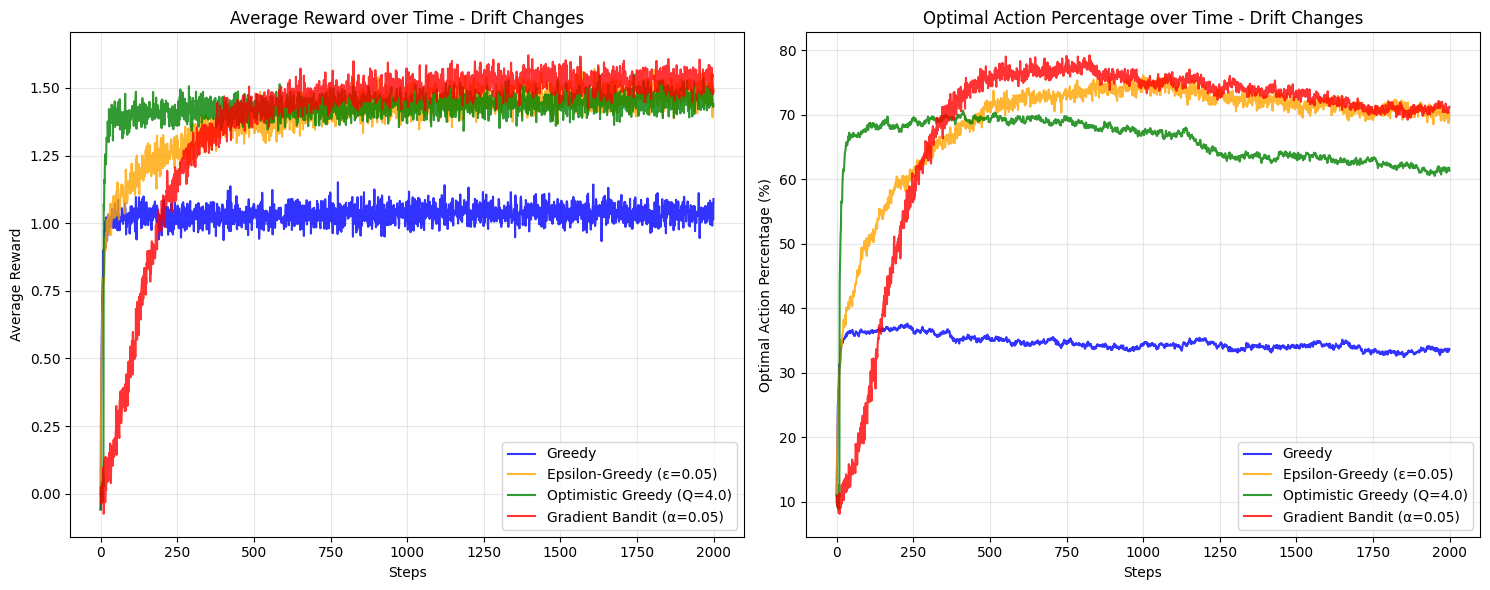

In [ ]:
# Run drift experiment and display results
print("Running Non-Stationary Multi-Armed Bandit - Drift Changes")
print(f"Configuration: {k} arms, {steps} steps, {simulations} simulations")
print("=" * 60)

algorithms = ["greedy", "epsilon", "optimistic", "gradient"]
algorithm_names = {
    "greedy": "Greedy",
    "epsilon": "Epsilon-Greedy",
    "optimistic": "Optimistic Greedy",
    "gradient": "Gradient Bandit"
}

results = {}

# Run experiments for each algorithm
for alg in algorithms:
    print(f"Running {algorithm_names[alg]}...")
    avg_rewards, opt_actions = run_bandit(algorithm=alg, update_type="drift")
    results[alg] = {
        'rewards': avg_rewards,
        'optimal_actions': opt_actions
    }

# Display results table
print("\nFinal Performance Metrics (Drift Changes):")
print("=" * 60)
print(f"{'Algorithm':<20} | {'Final Reward':<12} | {'Final Optimal%':<13} | {'Overall Avg':<12}")
print("=" * 60)

for alg in algorithms:
    final_reward = results[alg]['rewards'][-1]
    final_optimal = results[alg]['optimal_actions'][-1]
    overall_avg = np.mean(results[alg]['rewards'])
    print(f"{algorithm_names[alg]:<20} | {final_reward:>11.3f} | {final_optimal:>12.1f}% | {overall_avg:>11.3f}")

# Create plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

colors = ['blue', 'orange', 'green', 'red']
labels = [
    'Greedy',
    'Epsilon-Greedy (ε=0.05)',
    'Optimistic Greedy (Q=4.0)',
    'Gradient Bandit (α=0.05)'
]

# Plot 1: Average Reward over Time
for i, alg in enumerate(algorithms):
    ax1.plot(results[alg]['rewards'], color=colors[i], label=labels[i],
            alpha=0.8, linewidth=1.5)

ax1.set_xlabel('Steps')
ax1.set_ylabel('Average Reward')
ax1.set_title('Average Reward over Time - Drift Changes')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Optimal Action Percentage over Time
for i, alg in enumerate(algorithms):
    ax2.plot(results[alg]['optimal_actions'], color=colors[i], label=labels[i],
            alpha=0.8, linewidth=1.5)

ax2.set_xlabel('Steps')
ax2.set_ylabel('Optimal Action Percentage (%)')
ax2.set_title('Optimal Action Percentage over Time - Drift Changes')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Mean Reverting Changes

Running Non-Stationary Multi-Armed Bandit - Mean Reverting Changes
Configuration: 10 arms, 2000 steps, 1000 simulations
Running Greedy with mean reverting changes...
Running Epsilon-Greedy with mean reverting changes...
Running Optimistic Greedy with mean reverting changes...
Running Gradient Bandit with mean reverting changes...

Final Performance Metrics (Mean Reverting Changes):
Algorithm            | Final Reward | Final Optimal% | Overall Avg 
Greedy               |      -0.019 |          8.7% |      -0.001
Epsilon-Greedy       |      -0.001 |          9.1% |      -0.000
Optimistic Greedy    |      -0.026 |          9.3% |      -0.000
Gradient Bandit      |      -0.049 |          9.5% |       0.001


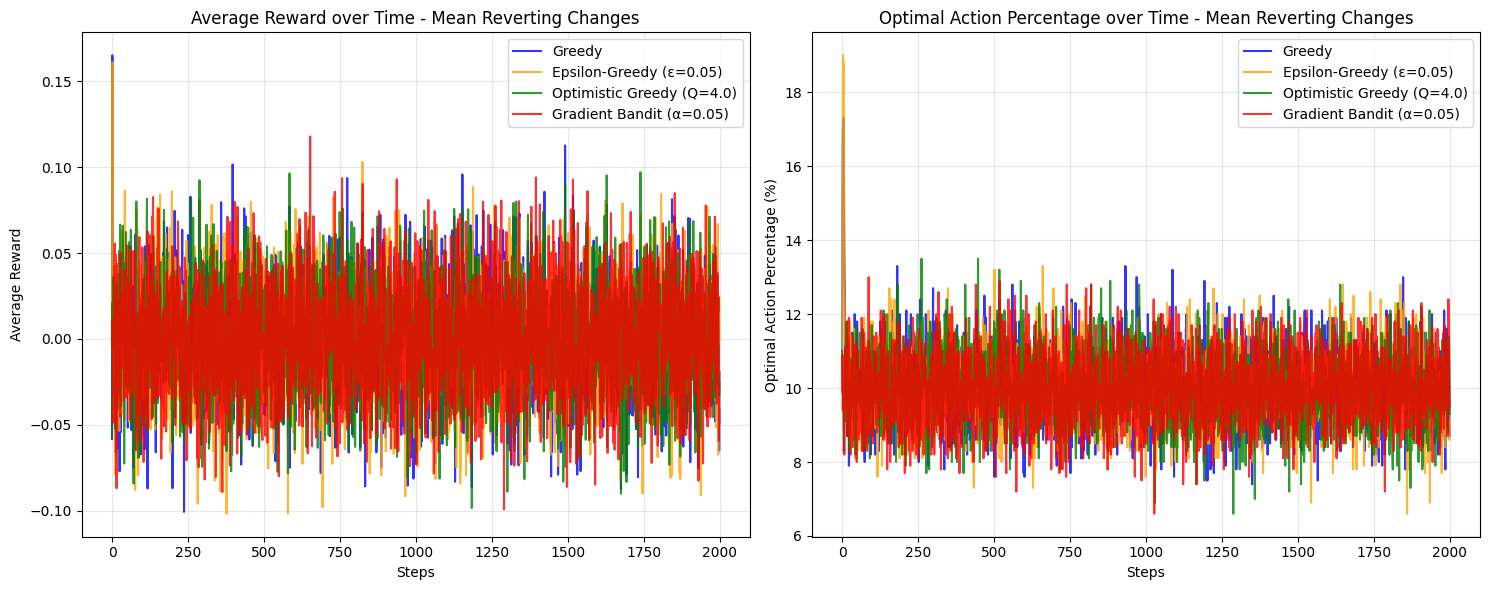

In [ ]:
# Run Mean Reverting Experiment
# Assuming the previous code with run_bandit function is already executed
# Mathematical Model: μ_{i,t} = κμ_{i,t-1} + ε_{i,t}, where κappa=0.5, ε ~ N(0, 0.01²)

print("Running Non-Stationary Multi-Armed Bandit - Mean Reverting Changes")
print(f"Configuration: {k} arms, {steps} steps, {simulations} simulations")
print("=" * 70)

algorithms = ["greedy", "epsilon", "optimistic", "gradient"]
algorithm_names = {
    "greedy": "Greedy",
    "epsilon": "Epsilon-Greedy",
    "optimistic": "Optimistic Greedy",
    "gradient": "Gradient Bandit"
}

results_mean_reverting = {}

# Run experiments for each algorithm with mean reverting changes
for alg in algorithms:
    print(f"Running {algorithm_names[alg]} with mean reverting changes...")
    avg_rewards, opt_actions = run_bandit(algorithm=alg, update_type="mean_reverting")
    results_mean_reverting[alg] = {
        'rewards': avg_rewards,
        'optimal_actions': opt_actions
    }

# Display results table
print("\nFinal Performance Metrics (Mean Reverting Changes):")
print("=" * 70)
print(f"{'Algorithm':<20} | {'Final Reward':<12} | {'Final Optimal%':<13} | {'Overall Avg':<12}")
print("=" * 70)

for alg in algorithms:
    final_reward = results_mean_reverting[alg]['rewards'][-1]
    final_optimal = results_mean_reverting[alg]['optimal_actions'][-1]
    overall_avg = np.mean(results_mean_reverting[alg]['rewards'])
    print(f"{algorithm_names[alg]:<20} | {final_reward:>11.3f} | {final_optimal:>12.1f}% | {overall_avg:>11.3f}")

# Create performance plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

colors = ['blue', 'orange', 'green', 'red']
labels = [
    'Greedy',
    'Epsilon-Greedy (ε=0.05)',
    'Optimistic Greedy (Q=4.0)',
    'Gradient Bandit (α=0.05)'
]

# Plot 1: Average Reward over Time
for i, alg in enumerate(algorithms):
    ax1.plot(results_mean_reverting[alg]['rewards'], color=colors[i], label=labels[i],
            alpha=0.8, linewidth=1.5)

ax1.set_xlabel('Steps')
ax1.set_ylabel('Average Reward')
ax1.set_title('Average Reward over Time - Mean Reverting Changes')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Optimal Action Percentage over Time
for i, alg in enumerate(algorithms):
    ax2.plot(results_mean_reverting[alg]['optimal_actions'], color=colors[i], label=labels[i],
            alpha=0.8, linewidth=1.5)

ax2.set_xlabel('Steps')
ax2.set_ylabel('Optimal Action Percentage (%)')
ax2.set_title('Optimal Action Percentage over Time - Mean Reverting Changes')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Abrupt Changes

### Abrupt changes as keep running the algorithms

Running Non-Stationary Multi-Armed Bandit - Abrupt Changes
Configuration: 10 arms, 2000 steps, 1000 simulations
Running Greedy with abrupt changes (no reset)...
Running Epsilon-Greedy with abrupt changes (no reset)...
Running Optimistic Greedy with abrupt changes (no reset)...
Running Gradient Bandit with abrupt changes (no reset)...

Pre vs. Post Change Analysis:
Algorithm            | Pre-Change (1-500) | Post-Change (501-2000) | Recovery
Greedy               |           0.998 |             0.450 | 1014 steps
Epsilon-Greedy       |           1.224 |             0.981 | 828 steps
Optimistic Greedy    |           1.370 |             0.639 | 904 steps
Gradient Bandit      |           0.970 |             0.640 | 1084 steps

Final Performance Metrics (Abrupt Changes - No Reset):
Algorithm            | Final Reward | Final Optimal% | Overall Avg 
Greedy               |       0.632 |         22.4% |       0.587
Epsilon-Greedy       |       1.346 |         64.1% |       1.041
Optimistic Gree

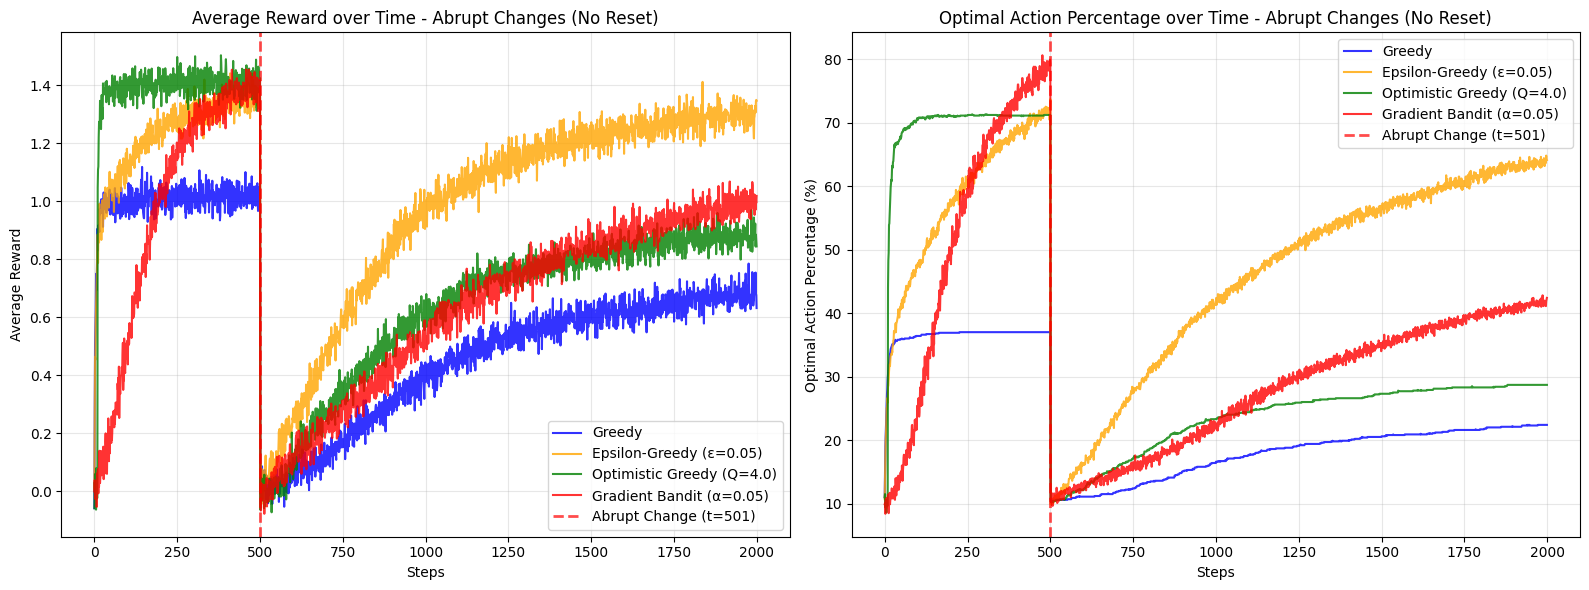

In [ ]:
# Run Abrupt Changes Experiment (No Reset)
# Assuming the previous code with run_bandit function is already executed

print("Running Non-Stationary Multi-Armed Bandit - Abrupt Changes")
print(f"Configuration: {k} arms, {steps} steps, {simulations} simulations")

print("=" * 75)

algorithms = ["greedy", "epsilon", "optimistic", "gradient"]
algorithm_names = {
    "greedy": "Greedy",
    "epsilon": "Epsilon-Greedy",
    "optimistic": "Optimistic Greedy",
    "gradient": "Gradient Bandit"
}

results_abrupt_no_reset = {}

# Run experiments for each algorithm with abrupt changes (no reset)
for alg in algorithms:
    print(f"Running {algorithm_names[alg]} with abrupt changes (no reset)...")
    avg_rewards, opt_actions = run_bandit(algorithm=alg, update_type="abrupt", reset=False)
    results_abrupt_no_reset[alg] = {
        'rewards': avg_rewards,
        'optimal_actions': opt_actions
    }

# Calculate pre-change and post-change performance
change_point = 500  # t=501 means index 500

print("\nPre vs. Post Change Analysis:")
print("=" * 80)
print(f"{'Algorithm':<20} | {'Pre-Change (1-500)':<16} | {'Post-Change (501-2000)':<18} | {'Recovery':<8}")
print("=" * 80)

recovery_times = {}

for alg in algorithms:
    # Pre-change performance (steps 0-499)
    pre_change_reward = np.mean(results_abrupt_no_reset[alg]['rewards'][:change_point])

    # Post-change performance (steps 500-1999)
    post_change_reward = np.mean(results_abrupt_no_reset[alg]['rewards'][change_point:])

    # Calculate recovery time (steps to reach stable performance after change)
    post_change_rewards = results_abrupt_no_reset[alg]['rewards'][change_point:]

    # Define "recovery" as when performance reaches 90% of final 200 steps average
    final_performance = np.mean(post_change_rewards[-200:])
    recovery_threshold = 0.9 * final_performance

    # Find first step where performance exceeds threshold for sustained period
    recovery_time = "500+ steps"
    for i in range(50, len(post_change_rewards) - 50):
        if np.mean(post_change_rewards[i-25:i+25]) >= recovery_threshold:
            recovery_time = f"{i} steps"
            break

    recovery_times[alg] = recovery_time

    print(f"{algorithm_names[alg]:<20} | {pre_change_reward:>15.3f} | {post_change_reward:>17.3f} | {recovery_time:>7}")

# Display final performance metrics
print("\nFinal Performance Metrics (Abrupt Changes - No Reset):")
print("=" * 70)
print(f"{'Algorithm':<20} | {'Final Reward':<12} | {'Final Optimal%':<13} | {'Overall Avg':<12}")
print("=" * 70)

for alg in algorithms:
    final_reward = results_abrupt_no_reset[alg]['rewards'][-1]
    final_optimal = results_abrupt_no_reset[alg]['optimal_actions'][-1]
    overall_avg = np.mean(results_abrupt_no_reset[alg]['rewards'])
    print(f"{algorithm_names[alg]:<20} | {final_reward:>11.3f} | {final_optimal:>12.1f}% | {overall_avg:>11.3f}")

# Create performance plots with change point marked
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = ['blue', 'orange', 'green', 'red']
labels = [
    'Greedy',
    'Epsilon-Greedy (ε=0.05)',
    'Optimistic Greedy (Q=4.0)',
    'Gradient Bandit (α=0.05)'
]

# Plot 1: Average Reward over Time
for i, alg in enumerate(algorithms):
    ax1.plot(results_abrupt_no_reset[alg]['rewards'], color=colors[i], label=labels[i],
            alpha=0.8, linewidth=1.5)

# Mark the change point
ax1.axvline(x=change_point, color='red', linestyle='--', alpha=0.7, linewidth=2,
           label='Abrupt Change (t=501)')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Average Reward')
ax1.set_title('Average Reward over Time - Abrupt Changes (No Reset)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Optimal Action Percentage over Time
for i, alg in enumerate(algorithms):
    ax2.plot(results_abrupt_no_reset[alg]['optimal_actions'], color=colors[i], label=labels[i],
            alpha=0.8, linewidth=1.5)

# Mark the change point
ax2.axvline(x=change_point, color='red', linestyle='--', alpha=0.7, linewidth=2,
           label='Abrupt Change (t=501)')
ax2.set_xlabel('Steps')
ax2.set_ylabel('Optimal Action Percentage (%)')
ax2.set_title('Optimal Action Percentage over Time - Abrupt Changes (No Reset)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Abrupt changes by giving full reset

Running Non-Stationary Multi-Armed Bandit - Abrupt Changes (Hard Reset)
Configuration: 10 arms, 2000 steps, 1000 simulations
Algorithm State: All Q-values/preferences reset to initial state
Running Greedy with abrupt changes (hard reset)...
Running Epsilon-Greedy with abrupt changes (hard reset)...
Running Optimistic Greedy with abrupt changes (hard reset)...
Running Gradient Bandit with abrupt changes (hard reset)...

Pre vs. Post Change Analysis (With Reset):
Algorithm            | Pre-Change (1-500) | Post-Change (501-2000) | Recovery
Greedy               |           0.998 |             1.019 | 50 steps
Epsilon-Greedy       |           1.224 |             1.344 | 255 steps
Optimistic Greedy    |           1.370 |             1.389 | 50 steps
Gradient Bandit      |           0.970 |             1.309 | 378 steps

Final Performance Metrics (Abrupt Changes - With Reset):
Algorithm            | Final Reward | Final Optimal% | Overall Avg 
Greedy               |       1.010 |         36.

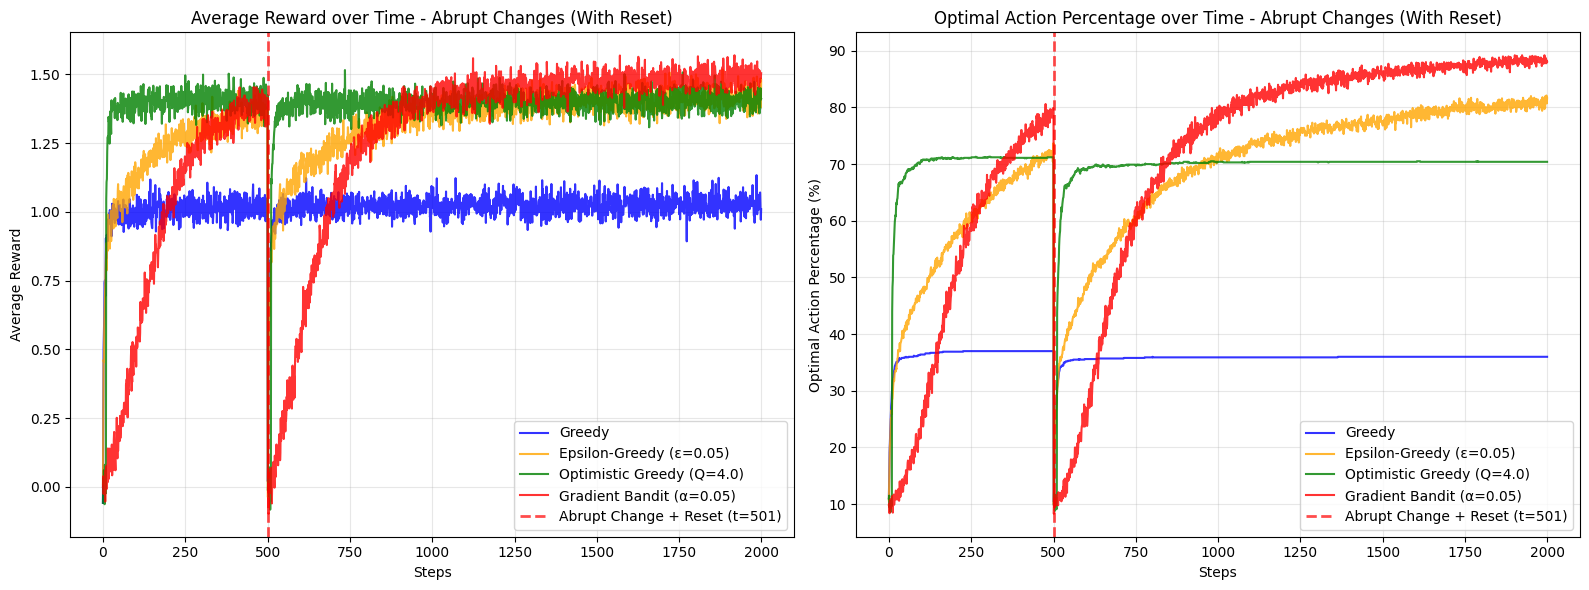

In [ ]:
# Run Abrupt Changes Experiment (With Reset)
# Assuming the previous code with run_bandit function is already executed

print("Running Non-Stationary Multi-Armed Bandit - Abrupt Changes (Hard Reset)")
print(f"Configuration: {k} arms, {steps} steps, {simulations} simulations")
print("Algorithm State: All Q-values/preferences reset to initial state")
print("=" * 75)

algorithms = ["greedy", "epsilon", "optimistic", "gradient"]
algorithm_names = {
    "greedy": "Greedy",
    "epsilon": "Epsilon-Greedy",
    "optimistic": "Optimistic Greedy",
    "gradient": "Gradient Bandit"
}

results_abrupt_with_reset = {}

# Run experiments for each algorithm with abrupt changes (with reset)
for alg in algorithms:
    print(f"Running {algorithm_names[alg]} with abrupt changes (hard reset)...")
    avg_rewards, opt_actions = run_bandit(algorithm=alg, update_type="abrupt", reset=True)
    results_abrupt_with_reset[alg] = {
        'rewards': avg_rewards,
        'optimal_actions': opt_actions
    }

# Calculate pre-change and post-change performance
change_point = 500  # t=501 means index 500

print("\nPre vs. Post Change Analysis (With Reset):")
print("=" * 80)
print(f"{'Algorithm':<20} | {'Pre-Change (1-500)':<16} | {'Post-Change (501-2000)':<18} | {'Recovery':<8}")
print("=" * 80)

recovery_times_reset = {}

for alg in algorithms:
    # Pre-change performance (steps 0-499)
    pre_change_reward = np.mean(results_abrupt_with_reset[alg]['rewards'][:change_point])

    # Post-change performance (steps 500-1999)
    post_change_reward = np.mean(results_abrupt_with_reset[alg]['rewards'][change_point:])

    # Calculate recovery time (steps to reach stable performance after change)
    post_change_rewards = results_abrupt_with_reset[alg]['rewards'][change_point:]

    # Define "recovery" as when performance reaches 90% of final 200 steps average
    final_performance = np.mean(post_change_rewards[-200:])
    recovery_threshold = 0.9 * final_performance

    # Find first step where performance exceeds threshold for sustained period
    recovery_time = "500+ steps"
    for i in range(50, len(post_change_rewards) - 50):
        if np.mean(post_change_rewards[i-25:i+25]) >= recovery_threshold:
            recovery_time = f"{i} steps"
            break

    recovery_times_reset[alg] = recovery_time

    print(f"{algorithm_names[alg]:<20} | {pre_change_reward:>15.3f} | {post_change_reward:>17.3f} | {recovery_time:>7}")

# Display final performance metrics
print("\nFinal Performance Metrics (Abrupt Changes - With Reset):")
print("=" * 70)
print(f"{'Algorithm':<20} | {'Final Reward':<12} | {'Final Optimal%':<13} | {'Overall Avg':<12}")
print("=" * 70)

for alg in algorithms:
    final_reward = results_abrupt_with_reset[alg]['rewards'][-1]
    final_optimal = results_abrupt_with_reset[alg]['optimal_actions'][-1]
    overall_avg = np.mean(results_abrupt_with_reset[alg]['rewards'])
    print(f"{algorithm_names[alg]:<20} | {final_reward:>11.3f} | {final_optimal:>12.1f}% | {overall_avg:>11.3f}")

# Compare No Reset vs Hard Reset
if 'results_abrupt_no_reset' in globals():
    print("\nComparison: No Reset vs Hard Reset:")
    print("=" * 75)
    print(f"{'Algorithm':<20} | {'No Reset Final':<13} | {'Hard Reset Final':<15} | {'Improvement':<11}")
    print("=" * 75)

    for alg in algorithms:
        no_reset_final = results_abrupt_no_reset[alg]['rewards'][-1]
        with_reset_final = results_abrupt_with_reset[alg]['rewards'][-1]
        improvement = with_reset_final - no_reset_final
        print(f"{algorithm_names[alg]:<20} | {no_reset_final:>12.3f} | {with_reset_final:>14.3f} | {improvement:>+10.3f}")

# Create performance plots with change point marked
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = ['blue', 'orange', 'green', 'red']
labels = [
    'Greedy',
    'Epsilon-Greedy (ε=0.05)',
    'Optimistic Greedy (Q=4.0)',
    'Gradient Bandit (α=0.05)'
]

# Plot 1: Average Reward over Time
for i, alg in enumerate(algorithms):
    ax1.plot(results_abrupt_with_reset[alg]['rewards'], color=colors[i], label=labels[i],
            alpha=0.8, linewidth=1.5)

# Mark the change point
ax1.axvline(x=change_point, color='red', linestyle='--', alpha=0.7, linewidth=2,
           label='Abrupt Change + Reset (t=501)')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Average Reward')
ax1.set_title('Average Reward over Time - Abrupt Changes (With Reset)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Optimal Action Percentage over Time
for i, alg in enumerate(algorithms):
    ax2.plot(results_abrupt_with_reset[alg]['optimal_actions'], color=colors[i], label=labels[i],
            alpha=0.8, linewidth=1.5)

# Mark the change point
ax2.axvline(x=change_point, color='red', linestyle='--', alpha=0.7, linewidth=2,
           label='Abrupt Change + Reset (t=501)')
ax2.set_xlabel('Steps')
ax2.set_ylabel('Optimal Action Percentage (%)')
ax2.set_title('Optimal Action Percentage over Time - Abrupt Changes (With Reset)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()